In [21]:
# ======================================
# IMPORTS & CONFIGURATION
# ======================================

import numpy as np
import pandas as pd

import lmfit
from lmfit import Model

# Path to the big table you just made
INPUT_CSV = "../paper1/csv/combined_sources_all_spw.csv"

# Minimum number of SPWs required
MIN_SPW_DETECTIONS = 4

# SPWs used in the catalog (must match column names)
SPW_ORDER = [15, 16, 17, 2, 3, 4, 5, 6, 8]

# Corresponding frequencies in MHz
SPW_FREQUENCIES_MHZ = {
    15: 1345.5883,
    16: 1409.5883,
    17: 1473.5883,
    2: 1653.5753,
    3: 1717.5753,
    4: 1781.57534,
    5: 1845.5753,
    6: 1909.5753,
    8: 2037.5753,
}


In [22]:
# ======================================
# LOAD BIG TABLE
# ======================================

df = pd.read_csv(INPUT_CSV)
print("Loaded table shape:", df.shape)


# ======================================
# COUNT SPW DETECTIONS PER SOURCE
# ======================================

def count_valid_spws(row, spw_list):
    """Count how many SPWs have a valid flux."""
    count = 0
    for spw in spw_list:
        if not np.isnan(row[f"Total_S_SPW{spw}"]):
            count += 1
    return count

df["N_SPW"] = df.apply(count_valid_spws, axis=1, spw_list=SPW_ORDER)

print(df["N_SPW"].value_counts().sort_index())


Loaded table shape: (1410, 50)
N_SPW
1    471
2     84
3     66
4     52
5     61
6     42
7     46
8     66
9    522
Name: count, dtype: int64


In [23]:
# ======================================
# FILTER SOURCES WITH ENOUGH SPWs
# ======================================

df_sel = df[df["N_SPW"] >= MIN_SPW_DETECTIONS].reset_index(drop=True)

print("Sources with enough detections:", len(df_sel))
df_sel[["Source_ID", "N_SPW"]].head()


Sources with enough detections: 789


,Source_ID,N_SPW
0,VPR J032942.6+320502.7,4
1,VPR J032940.2+312455.1,7
2,VPR J032911.6+323609.2,5
3,VPR J032843.1+313912.5,9
4,VPR J032840.4+304954.5,5


In [24]:
# ======================================
# EXTRACT SPECTRA PER SOURCE
# ======================================

def extract_spectrum(row):
    """
    Extract frequency, flux, and flux error arrays
    from one row of the wide table.
    """
    freqs = []
    fluxes = []
    errors = []

    for spw in SPW_ORDER:
        flux = row[f"Total_S_SPW{spw}"]
        err  = row[f"E_Total_S_SPW{spw}"]

        if np.isfinite(flux) and np.isfinite(err) and flux > 0 and err > 0:
            freqs.append(SPW_FREQUENCIES_MHZ[spw])
            fluxes.append(flux)
            errors.append(err)

    return np.array(freqs), np.array(fluxes), np.array(errors)


In [25]:
# ======================================
# POWER-LAW MODEL
# ======================================

NU0 = 1400.0  # MHz (reference frequency)

def power_law(nu, A, alpha):
    return A * (nu / NU0) ** alpha

pl_model = Model(power_law)


In [26]:
# ======================================
# CELL 6: FIT SPECTRAL INDICES WITH LMFIT ONLY
# ======================================

combined_results = []

for idx, row in df_sel.iterrows():
    # extract usable spectrum for this source
    freqs, fluxes, errors = extract_spectrum(row)

    # require at least MIN_SPW_DETECTIONS valid points
    if len(freqs) < MIN_SPW_DETECTIONS:
        continue

    # initial parameter guesses
    params = pl_model.make_params(
        A=np.median(fluxes),
        alpha=-0.7,   # typical synchrotron-ish slope
    )

    # weighted least-squares fit in linear flux space
    lmfit_result = pl_model.fit(
        fluxes,
        params,
        nu=freqs,
        weights=1.0 / errors
    )

    alpha_lm   = lmfit_result.params["alpha"].value
    e_alpha_lm = lmfit_result.params["alpha"].stderr
    A_lm       = lmfit_result.params["A"].value
    e_A_lm     = lmfit_result.params["A"].stderr
    chi2_red   = lmfit_result.redchi

    combined_results.append({
        "Source_ID": row["Source_ID"],
        "N_SPW_used": len(freqs),

        "alpha_lmfit": alpha_lm,
        "E_alpha_lmfit": e_alpha_lm,
        "A_lmfit": A_lm,
        "E_A_lmfit": e_A_lm,
        "chi2_red_lmfit": chi2_red,
    })

alpha_all_df = pd.DataFrame(combined_results)
print("Total entries in alpha_all_df:", len(alpha_all_df))
alpha_all_df.tail()


Total entries in alpha_all_df: 789


,Source_ID,N_SPW_used,alpha_lmfit,E_alpha_lmfit,A_lmfit,E_A_lmfit,chi2_red_lmfit
784,VPR J031928.2+302027.6,4,4.141781,1.113474,26.562858,8.336030,0.200717
785,VPR J033326.2+313807.5,5,0.574279,3.191487,1.279674,1.199379,2.406946
786,VPR J033957.4+291826.4,4,6.493479,1.071368,42.436400,13.721851,0.652450
787,VPR J032945.4+311552.0,5,8.621035,3.529765,16.508091,17.692066,10.924601
788,VPR J033250.1+303328.2,4,1.047059,2.759419,1.257388,1.051321,1.286474


In [27]:
# ======================================
# SAVE GOOD LMFIT FITS TO A FILE
# ======================================

import pandas as pd
import numpy as np

# (alpha_all_df already exists from previous cells)

CHI2_MAX_LMFIT = 3.0
ERR_MAX        = 0.2   # max allowed σ(alpha)

# --------------------------------------
# Filter good lmfit fits
# --------------------------------------
mask_lm = (
    np.isfinite(alpha_all_df["alpha_lmfit"]) &
    np.isfinite(alpha_all_df["E_alpha_lmfit"]) &
    np.isfinite(alpha_all_df["chi2_red_lmfit"]) &
    (alpha_all_df["alpha_lmfit"] >= -3.0) &
    (alpha_all_df["alpha_lmfit"] <= 3.0) &
    (alpha_all_df["chi2_red_lmfit"] <= CHI2_MAX_LMFIT) &
    (alpha_all_df["E_alpha_lmfit"] <= ERR_MAX)
)

alpha_good_lmfit = alpha_all_df[mask_lm].reset_index(drop=True)

print(f"[lmfit] total fits: {len(alpha_all_df)}")
print(f"[lmfit] GOOD fits (|α|≤3, χ²≤{CHI2_MAX_LMFIT}, σ≤{ERR_MAX}): {len(alpha_good_lmfit)}")

# --------------------------------------
# Select only the needed columns
# --------------------------------------
to_save = alpha_good_lmfit[
    ["Source_ID", "alpha_lmfit", "E_alpha_lmfit", "chi2_red_lmfit"]
]

# --------------------------------------
# Save file
# --------------------------------------
OUTPUT_GOOD_ALPHA = "../paper1/csv/good_alpha_lmfit.csv"

to_save.to_csv(OUTPUT_GOOD_ALPHA, index=False)

print(f"✅ Saved GOOD lmfit α values to:\n    {OUTPUT_GOOD_ALPHA}\n")

to_save.head()


[lmfit] total fits: 789
[lmfit] GOOD fits (|α|≤3, χ²≤3.0, σ≤0.2): 275
✅ Saved GOOD lmfit α values to:
    ../paper1/csv/good_alpha_lmfit.csv



,Source_ID,alpha_lmfit,E_alpha_lmfit,chi2_red_lmfit
0,VPR J032843.1+313912.5,-0.557599,0.038241,1.114586
1,VPR J032827.4+302615.7,-1.283936,0.100948,1.478531
2,VPR J032819.3+313144.1,-1.000764,0.113234,1.449468
3,VPR J032802.9+305345.1,-0.380507,0.049182,0.167092
4,VPR J032803.6+305839.4,-1.230234,0.098352,0.296517


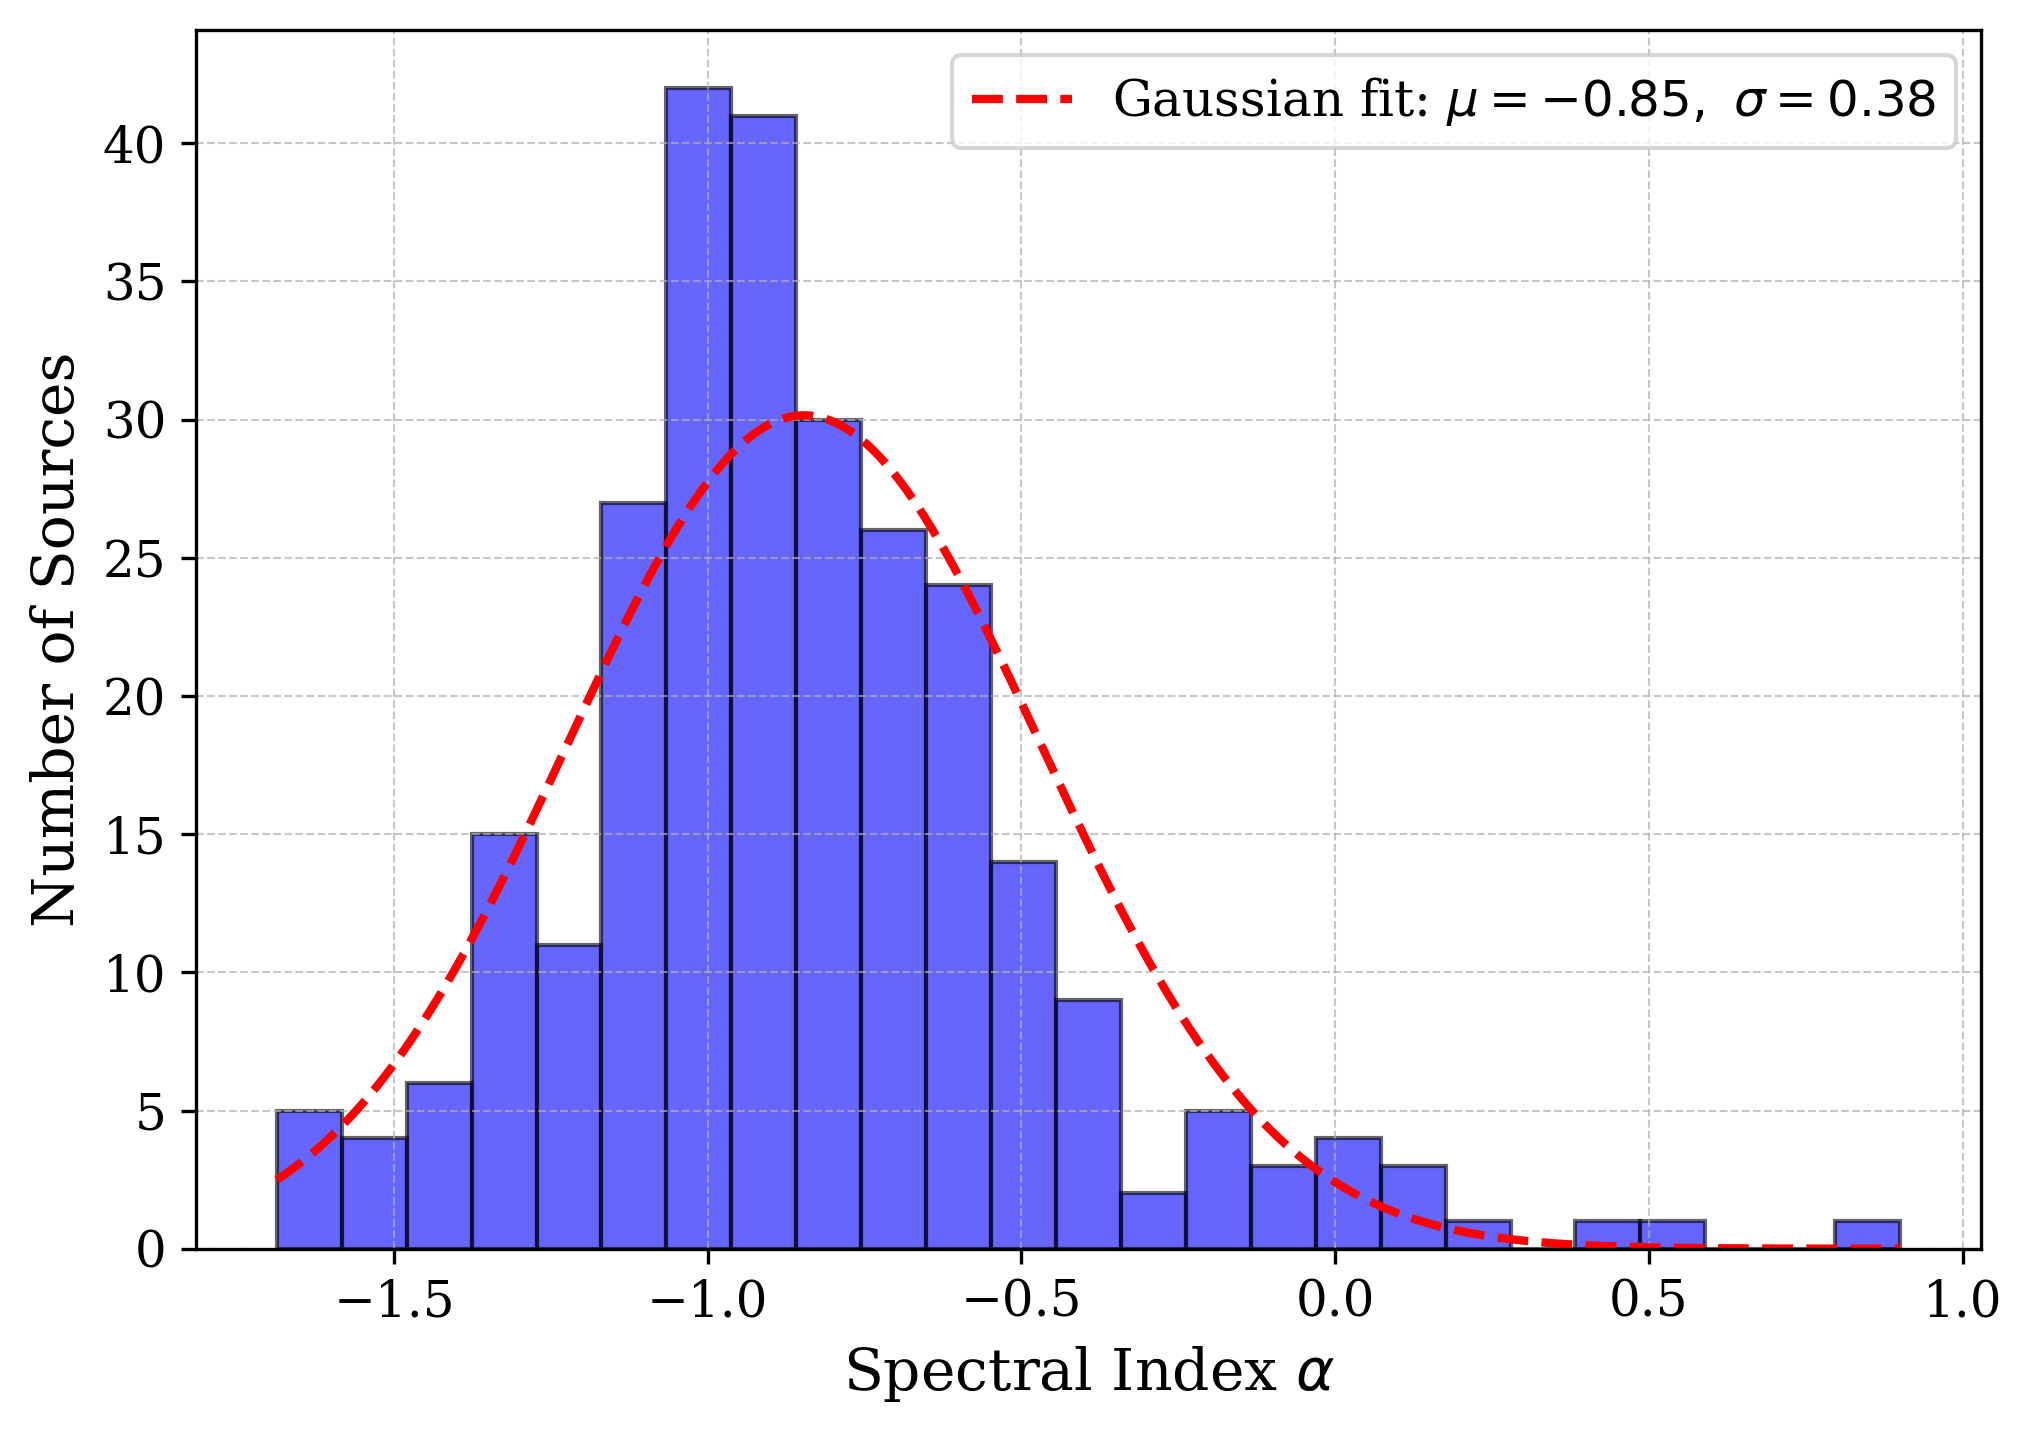

✅ Saved: ../paper1/figs/spectral_index_histogram_counts.pdf
   μ = -0.846, σ = 0.377


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# Load spectral indices (lmfit good fits)
# ======================================
alpha = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha) == 0:
    print("⚠️ No lmfit α values available.")
    raise SystemExit

# ======================================
# Single Gaussian fit
# ======================================
mu, sigma = norm.fit(alpha)

# ======================================
# Plot
# ======================================
fig, ax = plt.subplots(figsize=(7, 5))

counts, bins, _ = ax.hist(
    alpha,
    bins=25,
    color='blue',
    edgecolor='black',
    alpha=0.6
)

# Scale Gaussian to histogram counts
bin_width = bins[1] - bins[0]
x = np.linspace(bins[0], bins[-1], 1000)
y = norm.pdf(x, mu, sigma) * len(alpha) * bin_width

ax.plot(
    x, y,
    'r--',
    linewidth=2,
    label=rf'Gaussian fit: $\mu={mu:.2f},\ \sigma={sigma:.2f}$'
)

# Labels
ax.set_xlabel(r'Spectral Index $\alpha$')
ax.set_ylabel('Number of Sources')

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

plt.tight_layout()

# ======================================
# Save
# ======================================
out = '../paper1/figs/spectral_index_histogram_counts.pdf'
os.makedirs(os.path.dirname(out), exist_ok=True)
plt.savefig(out, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {out}")
print(f"   μ = {mu:.3f}, σ = {sigma:.3f}")


✅ Spectral index histogram saved to: ../paper1/figs/spectral_index_histogram_counts.pdf
   Mean α = -0.85,  σ = 0.38


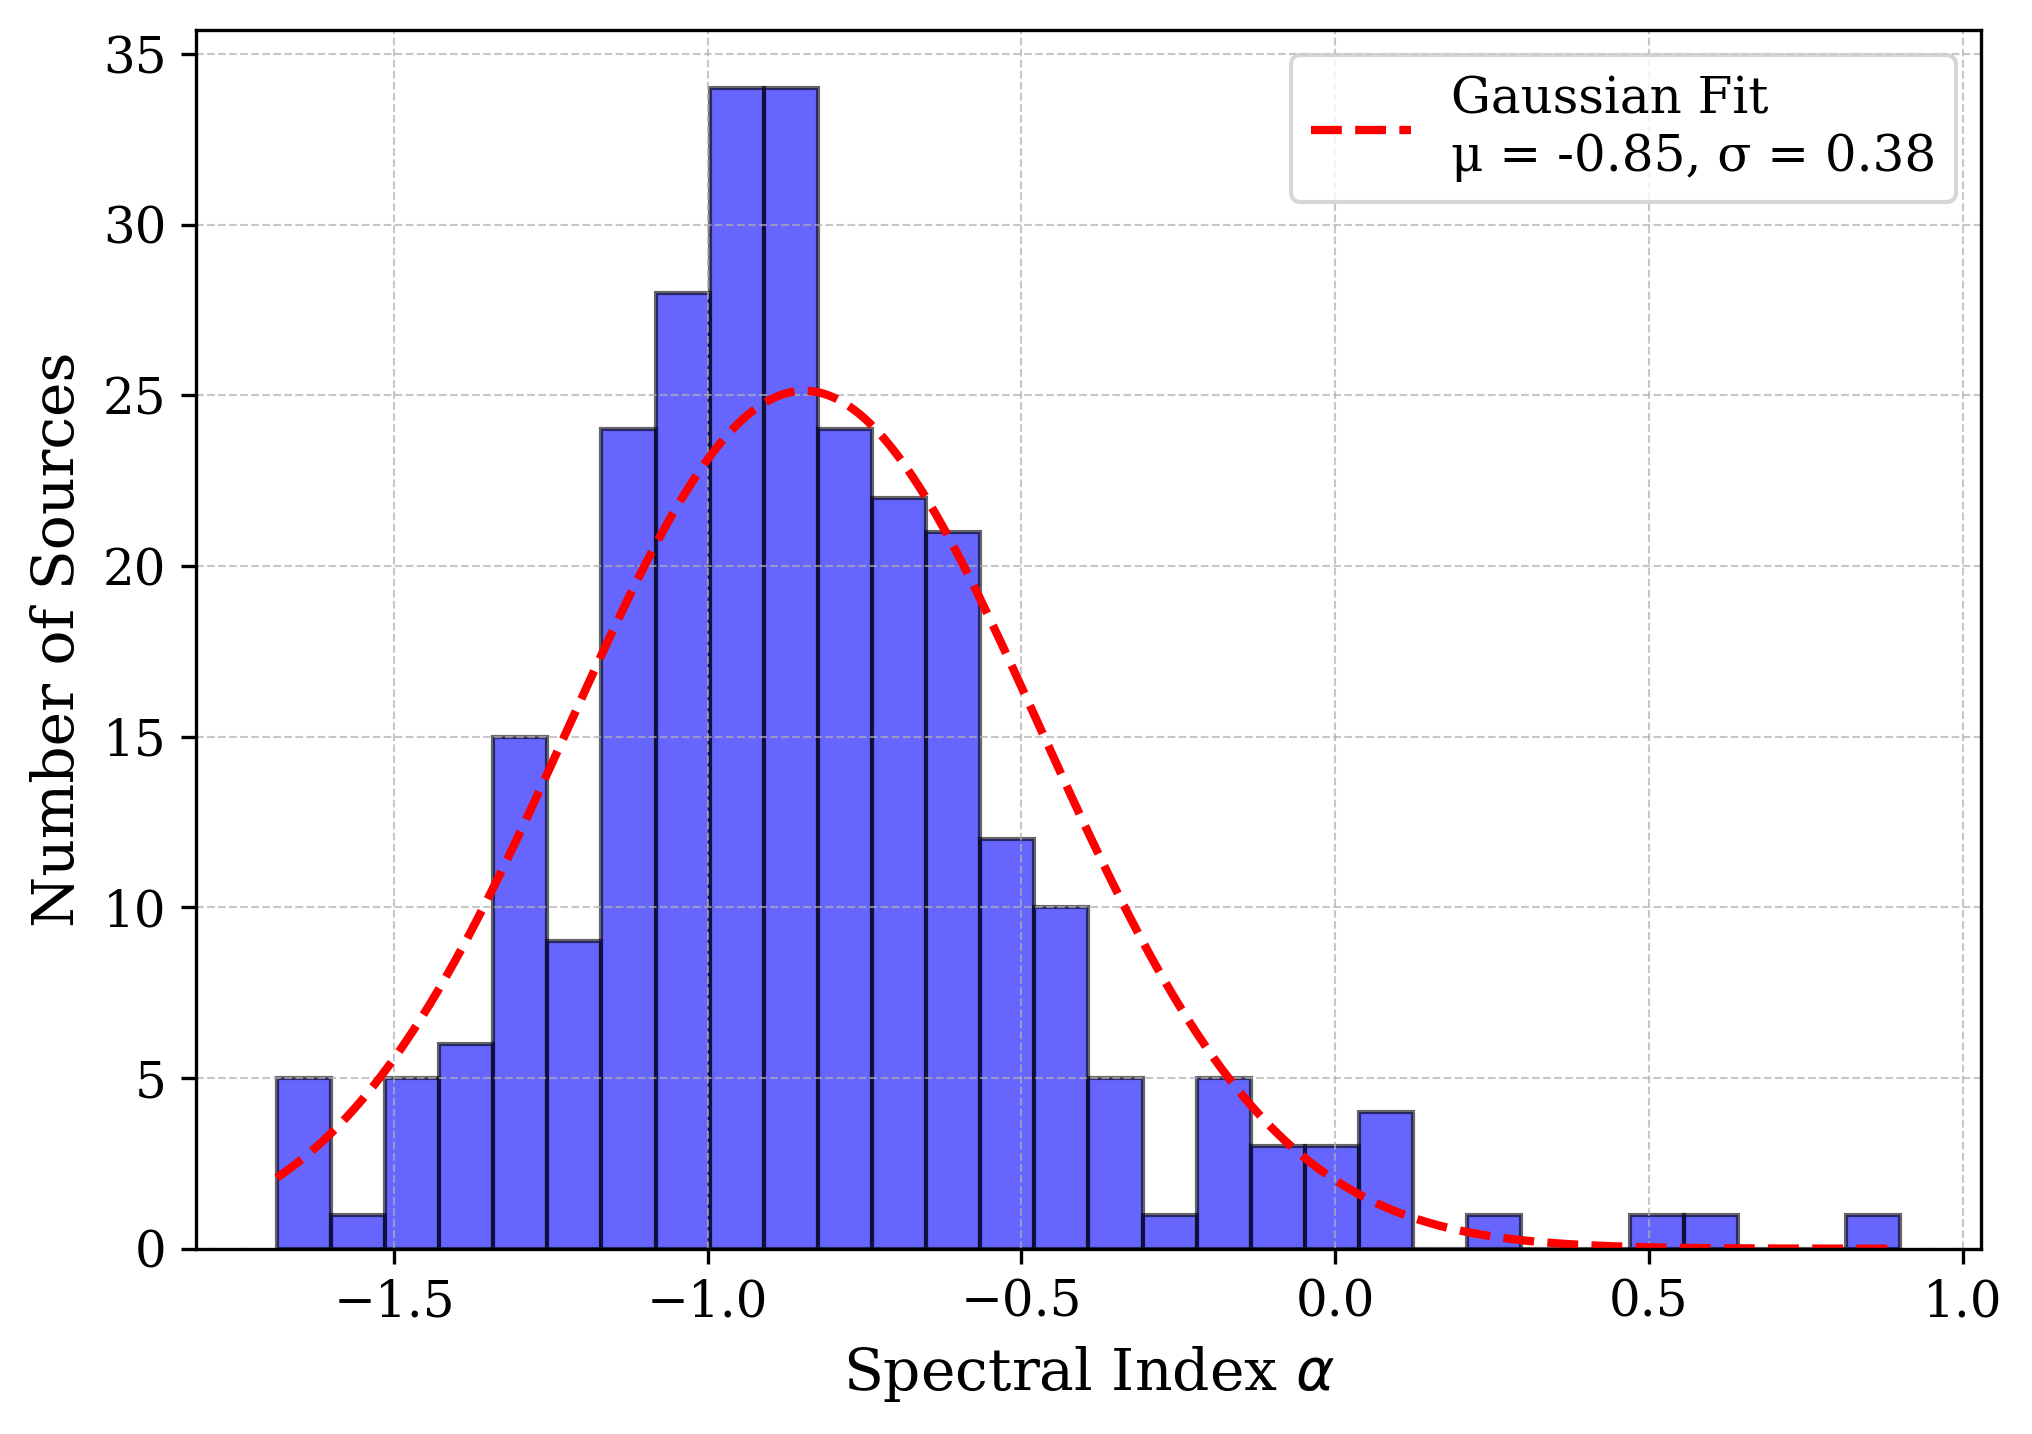

In [20]:
import matplotlib.pyplot as plt
# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# Spectral index histogram (lmfit good fits)
# ======================================

from scipy.stats import norm
import numpy as np
import os

alpha_lm_good = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha_lm_good) > 0:

    # Gaussian fit
    mu_lm, std_lm = norm.fit(alpha_lm_good)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Histogram — COUNTS
    counts, bins, _ = ax.hist(
        alpha_lm_good,
        bins=30,
        color='blue',
        edgecolor='black',
        alpha=0.6
    )

    # Scale Gaussian to histogram counts
    bin_width = bins[1] - bins[0]
    x = np.linspace(bins[0], bins[-1], 1000)
    y = norm.pdf(x, mu_lm, std_lm) * len(alpha_lm_good) * bin_width

    ax.plot(
        x,
        y,
        'r--',
        linewidth=2,
        label=f'Gaussian Fit\nμ = {mu_lm:.2f}, σ = {std_lm:.2f}'
    )

    # LABELS — styled by rcParams
    ax.set_xlabel(r'Spectral Index $\alpha$')
    ax.set_ylabel('Number of Sources')

    # MATCH GRID STYLE
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

    plt.tight_layout()

    # Save figure
    output_path = '../paper1/figs/spectral_index_histogram.pdf'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, bbox_inches='tight')

    print(f"✅ Spectral index histogram saved to: {output_path}")
    print(f"   Mean α = {mu_lm:.2f},  σ = {std_lm:.2f}")

    plt.show()

else:
    print("⚠️ No lmfit α values available.")


## Fit two Gaussians

✅ Saved to: ../paper1/figs/spectral_index_histogram_two_gauss.pdf
Steep: mu = -0.897, sigma = 0.276, A = 31.7
Flat : mu = -0.092, sigma = 0.300, A = 2.5
Total sources: 275


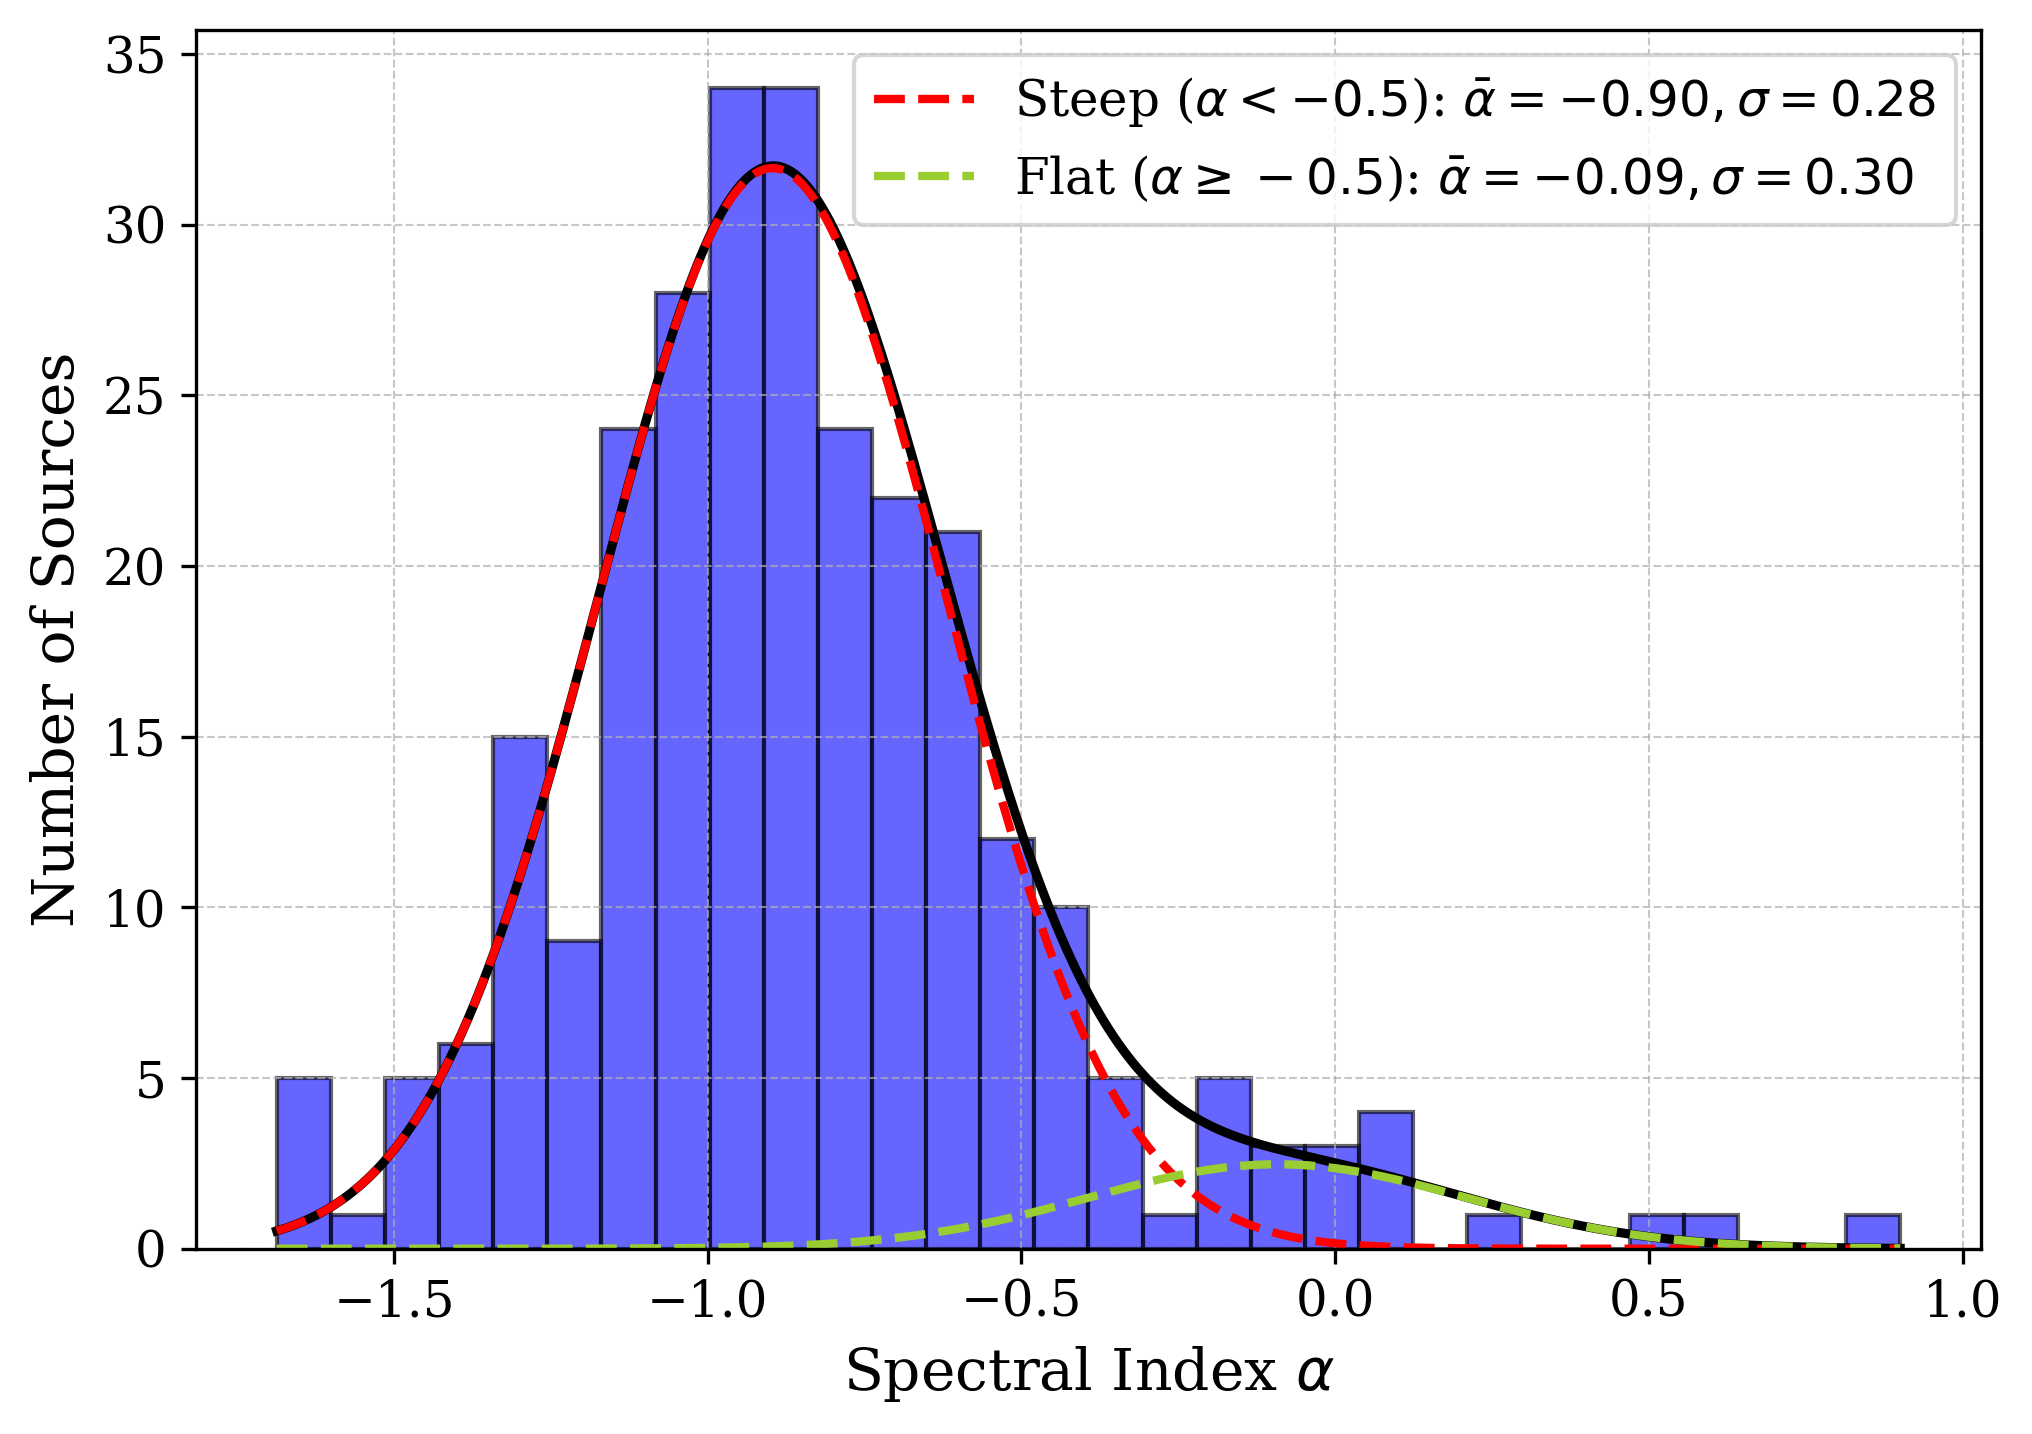

In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ======================================
# Global plot style (MATCHING RM HISTOGRAM)
# ======================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# ======================================
# Color-blind friendly LINE colors only
# (Histogram color remains unchanged)
# ======================================
COL_TOTAL = 'black'    # total fit
COL_STEEP = 'red'  # blue (Okabe–Ito)
COL_FLAT  = 'yellowgreen'  # orange (Okabe–Ito)
COL_SPLIT = '0.3'      # dark gray

# ======================================
# Helper: single Gaussian in counts
# ======================================
def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# ======================================
# Spectral index histogram (lmfit good fits)
# ======================================
alpha_lm_good = alpha_good_lmfit["alpha_lmfit"].dropna().values

if len(alpha_lm_good) > 0:

    fig, ax = plt.subplots(figsize=(7, 5))

    # Histogram in COUNTS (UNCHANGED color)
    counts, bins, _ = ax.hist(
        alpha_lm_good,
        bins=30,
        color='blue',
        edgecolor='black',
        alpha=0.6
    )
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # ======================================
    # 1) Fit STEEP component (central peak)
    # ======================================
    steep_region = (bin_centers > -1.6) & (bin_centers < -0.4)
    x_steep = bin_centers[steep_region]
    y_steep = counts[steep_region]

    if y_steep.sum() > 0:
        mu0_steep = np.sum(x_steep * y_steep) / np.sum(y_steep)
        sigma0_steep = np.sqrt(
            np.sum(y_steep * (x_steep - mu0_steep) ** 2) / np.sum(y_steep)
        )
    else:
        mu0_steep = np.median(alpha_lm_good)
        sigma0_steep = 0.2

    A0_steep = y_steep.max()

    p0_steep = [A0_steep, mu0_steep, max(sigma0_steep, 0.1)]
    bounds_steep = (
        [0.0, -1.5, 0.05],   # A>0, mu in left region, narrow-ish
        [np.inf, -0.5, 0.4]
    )

    A1_arr, mu1_arr, sigma1_arr = curve_fit(
        gauss,
        x_steep,
        y_steep,
        p0=p0_steep,
        bounds=bounds_steep
    )[0]

    A1     = float(A1_arr)
    mu1    = float(mu1_arr)
    sigma1 = float(sigma1_arr)

    steep_model_bins = gauss(bin_centers, A1, mu1, sigma1)

    # ======================================
    # 2) Fit FLAT component (residual tail)
    # ======================================
    residual = np.clip(counts - steep_model_bins, 0.0, None)

    flat_region = (bin_centers > -0.8) & (bin_centers < 1.0)
    x_flat = bin_centers[flat_region]
    y_flat = residual[flat_region]

    if y_flat.sum() > 0:
        mu0_flat = np.sum(x_flat * y_flat) / np.sum(y_flat)
        sigma0_flat = np.sqrt(
            np.sum(y_flat * (x_flat - mu0_flat) ** 2) / np.sum(y_flat)
        )
        A0_flat = y_flat.max()

        p0_flat = [A0_flat, mu0_flat, max(sigma0_flat, 0.3)]

        bounds_flat = (
            [0.0, -0.7, 0.3],   # A>0, mu ≥ -0.7, sigma ≥ 0.3 (broad)
            [np.inf,  0.6, 1.2] # mu ≤ 0.6, sigma ≤ 1.2
        )

        A2_arr, mu2_arr, sigma2_arr = curve_fit(
            gauss,
            x_flat,
            y_flat,
            p0=p0_flat,
            bounds=bounds_flat
        )[0]

        A2     = float(A2_arr)
        mu2    = float(mu2_arr)
        sigma2 = float(sigma2_arr)

        flat_model_bins = gauss(bin_centers, A2, mu2, sigma2)
    else:
        A2, mu2, sigma2 = 0.0, 0.0, 1.0
        flat_model_bins = np.zeros_like(bin_centers)

    # ======================================
    # 3) Smooth curves for plotting
    # ======================================
    x = np.linspace(bins[0], bins[-1], 1000)
    g1 = gauss(x, A1, mu1, sigma1)            # steep
    g2 = gauss(x, A2, mu2, sigma2)            # flat
    gtot = g1 + g2

    # ======================================
    # Plot components + total (LINES ONLY changed)
    # ======================================
    ax.plot(x, gtot, color=COL_TOTAL, linewidth=2.2)
    ax.plot(
        x, g1,
        linestyle='--', linewidth=2,
        color=COL_STEEP,
        label=fr'Steep ($\alpha < -0.5$): $\bar\alpha = {mu1:.2f}, \sigma = {sigma1:.2f}$'
    )
    ax.plot(
        x, g2,
        linestyle='--', linewidth=2,
        color=COL_FLAT,
        label=fr'Flat ($\alpha \geq -0.5$): $\bar\alpha = {mu2:.2f}, \sigma = {sigma2:.2f}$'
    )

    # # Canonical split between flat and steep spectrum sources
    # ax.axvline(
    #     -0.5,
    #     color=COL_SPLIT,
    #     linestyle=':',
    #     linewidth=2,
    #     # label=r'Canonical split $\alpha = -0.5$'
    # )

    ax.set_xlabel(r'Spectral Index $\alpha$')
    ax.set_ylabel('Number of Sources')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

    plt.tight_layout()

    out_path = '../paper1/figs/spectral_index_histogram_two_gauss.pdf'
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, bbox_inches='tight')

    print(f"✅ Saved to: {out_path}")
    print(f"Steep: mu = {mu1:.3f}, sigma = {sigma1:.3f}, A = {A1:.1f}")
    print(f"Flat : mu = {mu2:.3f}, sigma = {sigma2:.3f}, A = {A2:.1f}")
    print(f"Total sources: {len(alpha_lm_good)}")

    plt.show()

else:
    print("⚠️ No lmfit α values available.")


# Plot some spectral indices

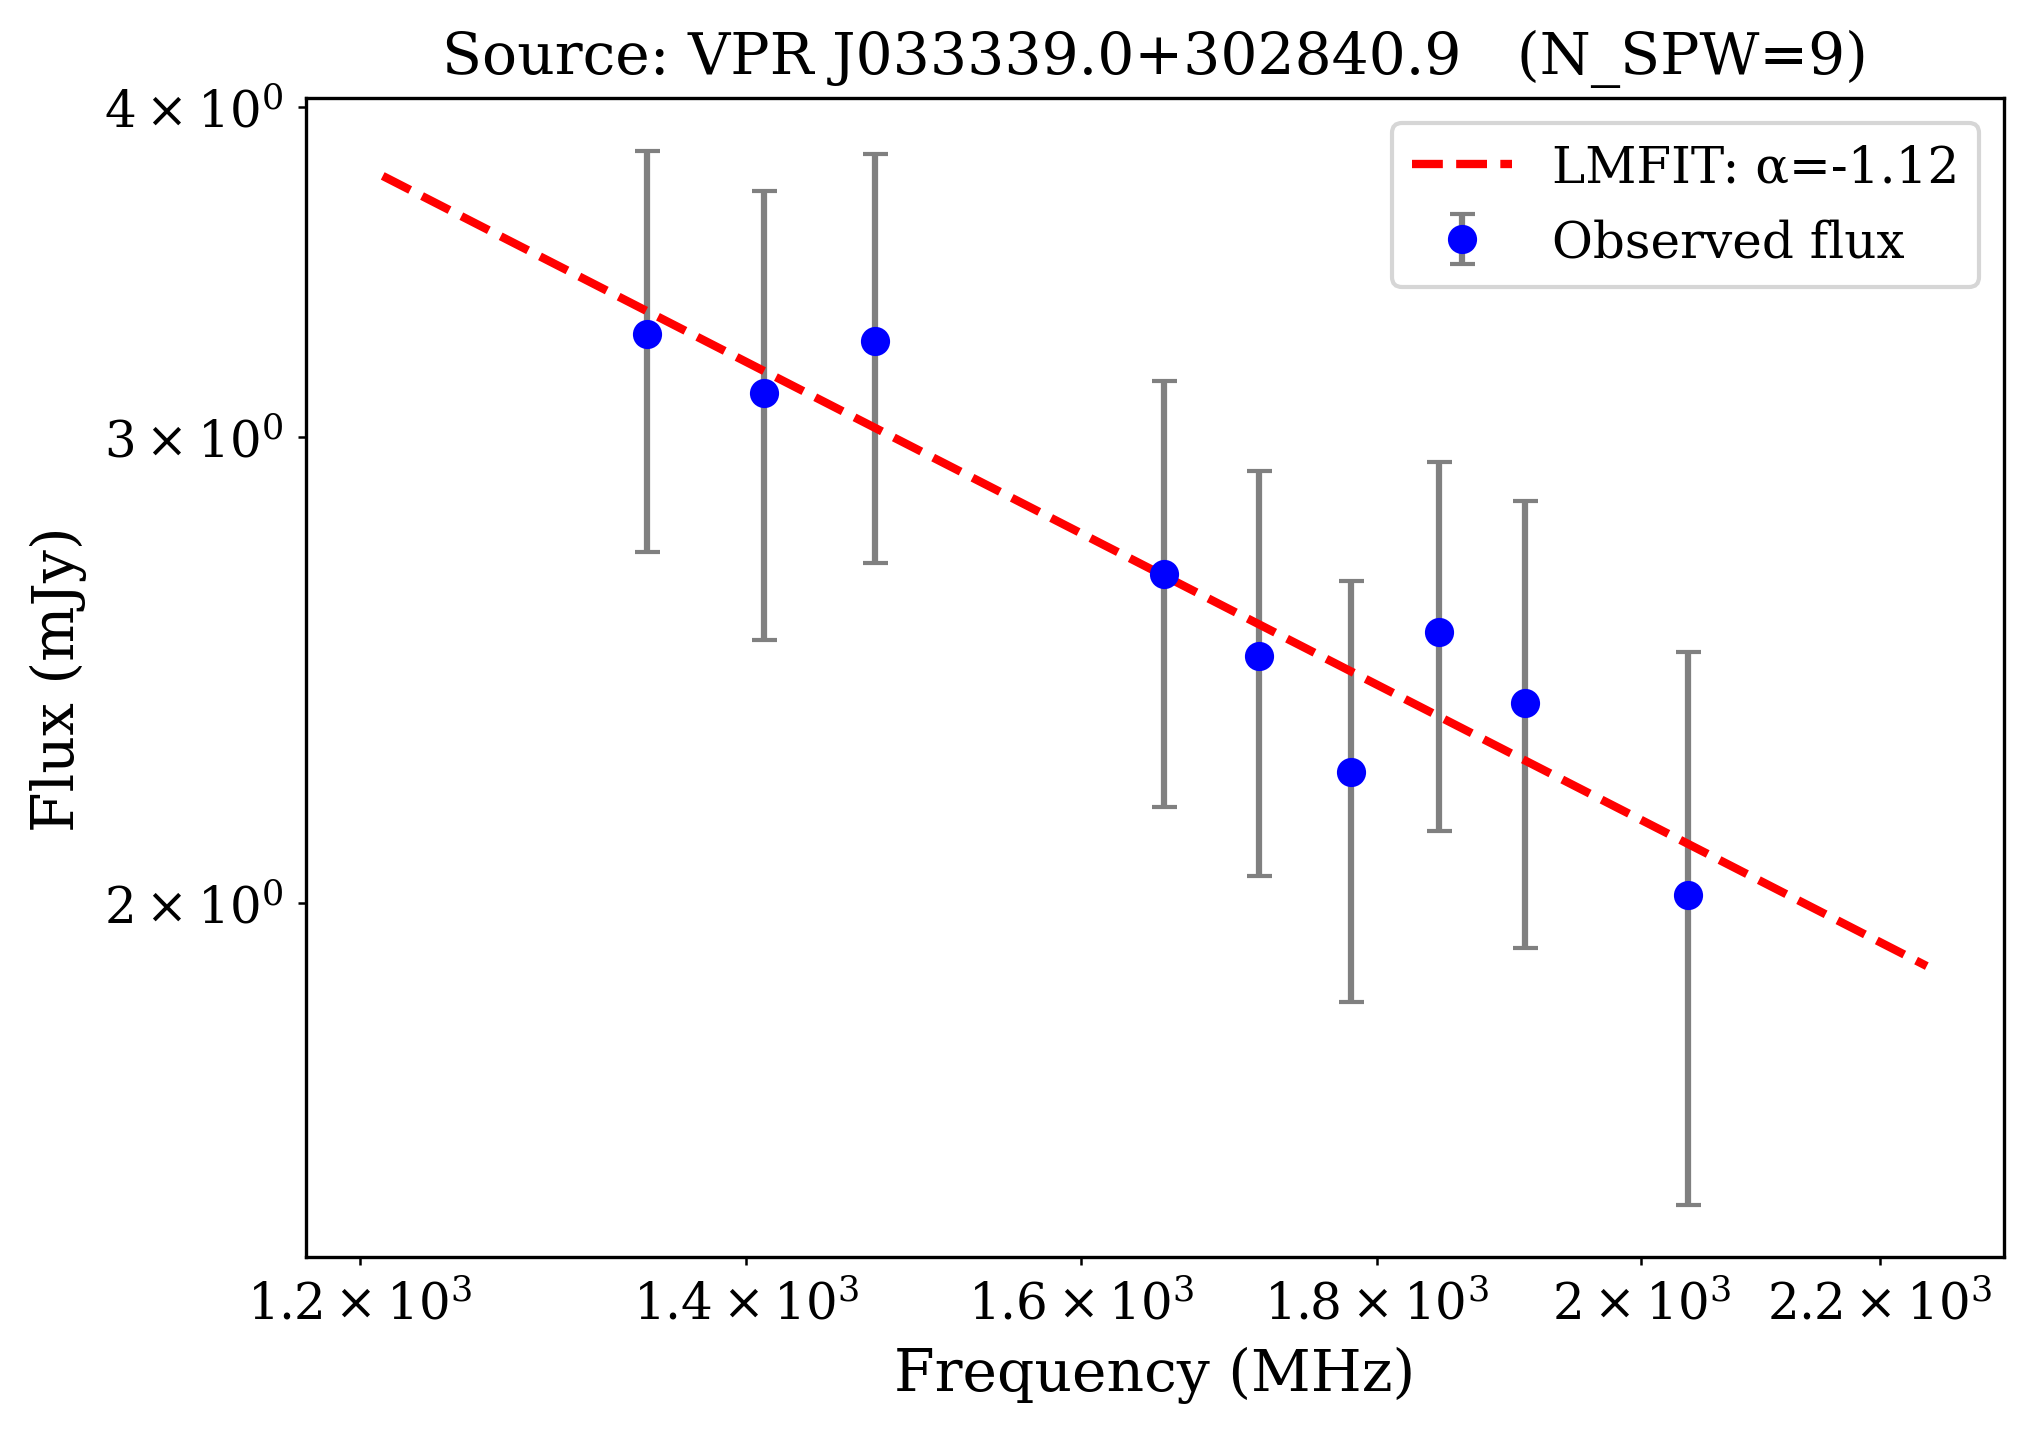

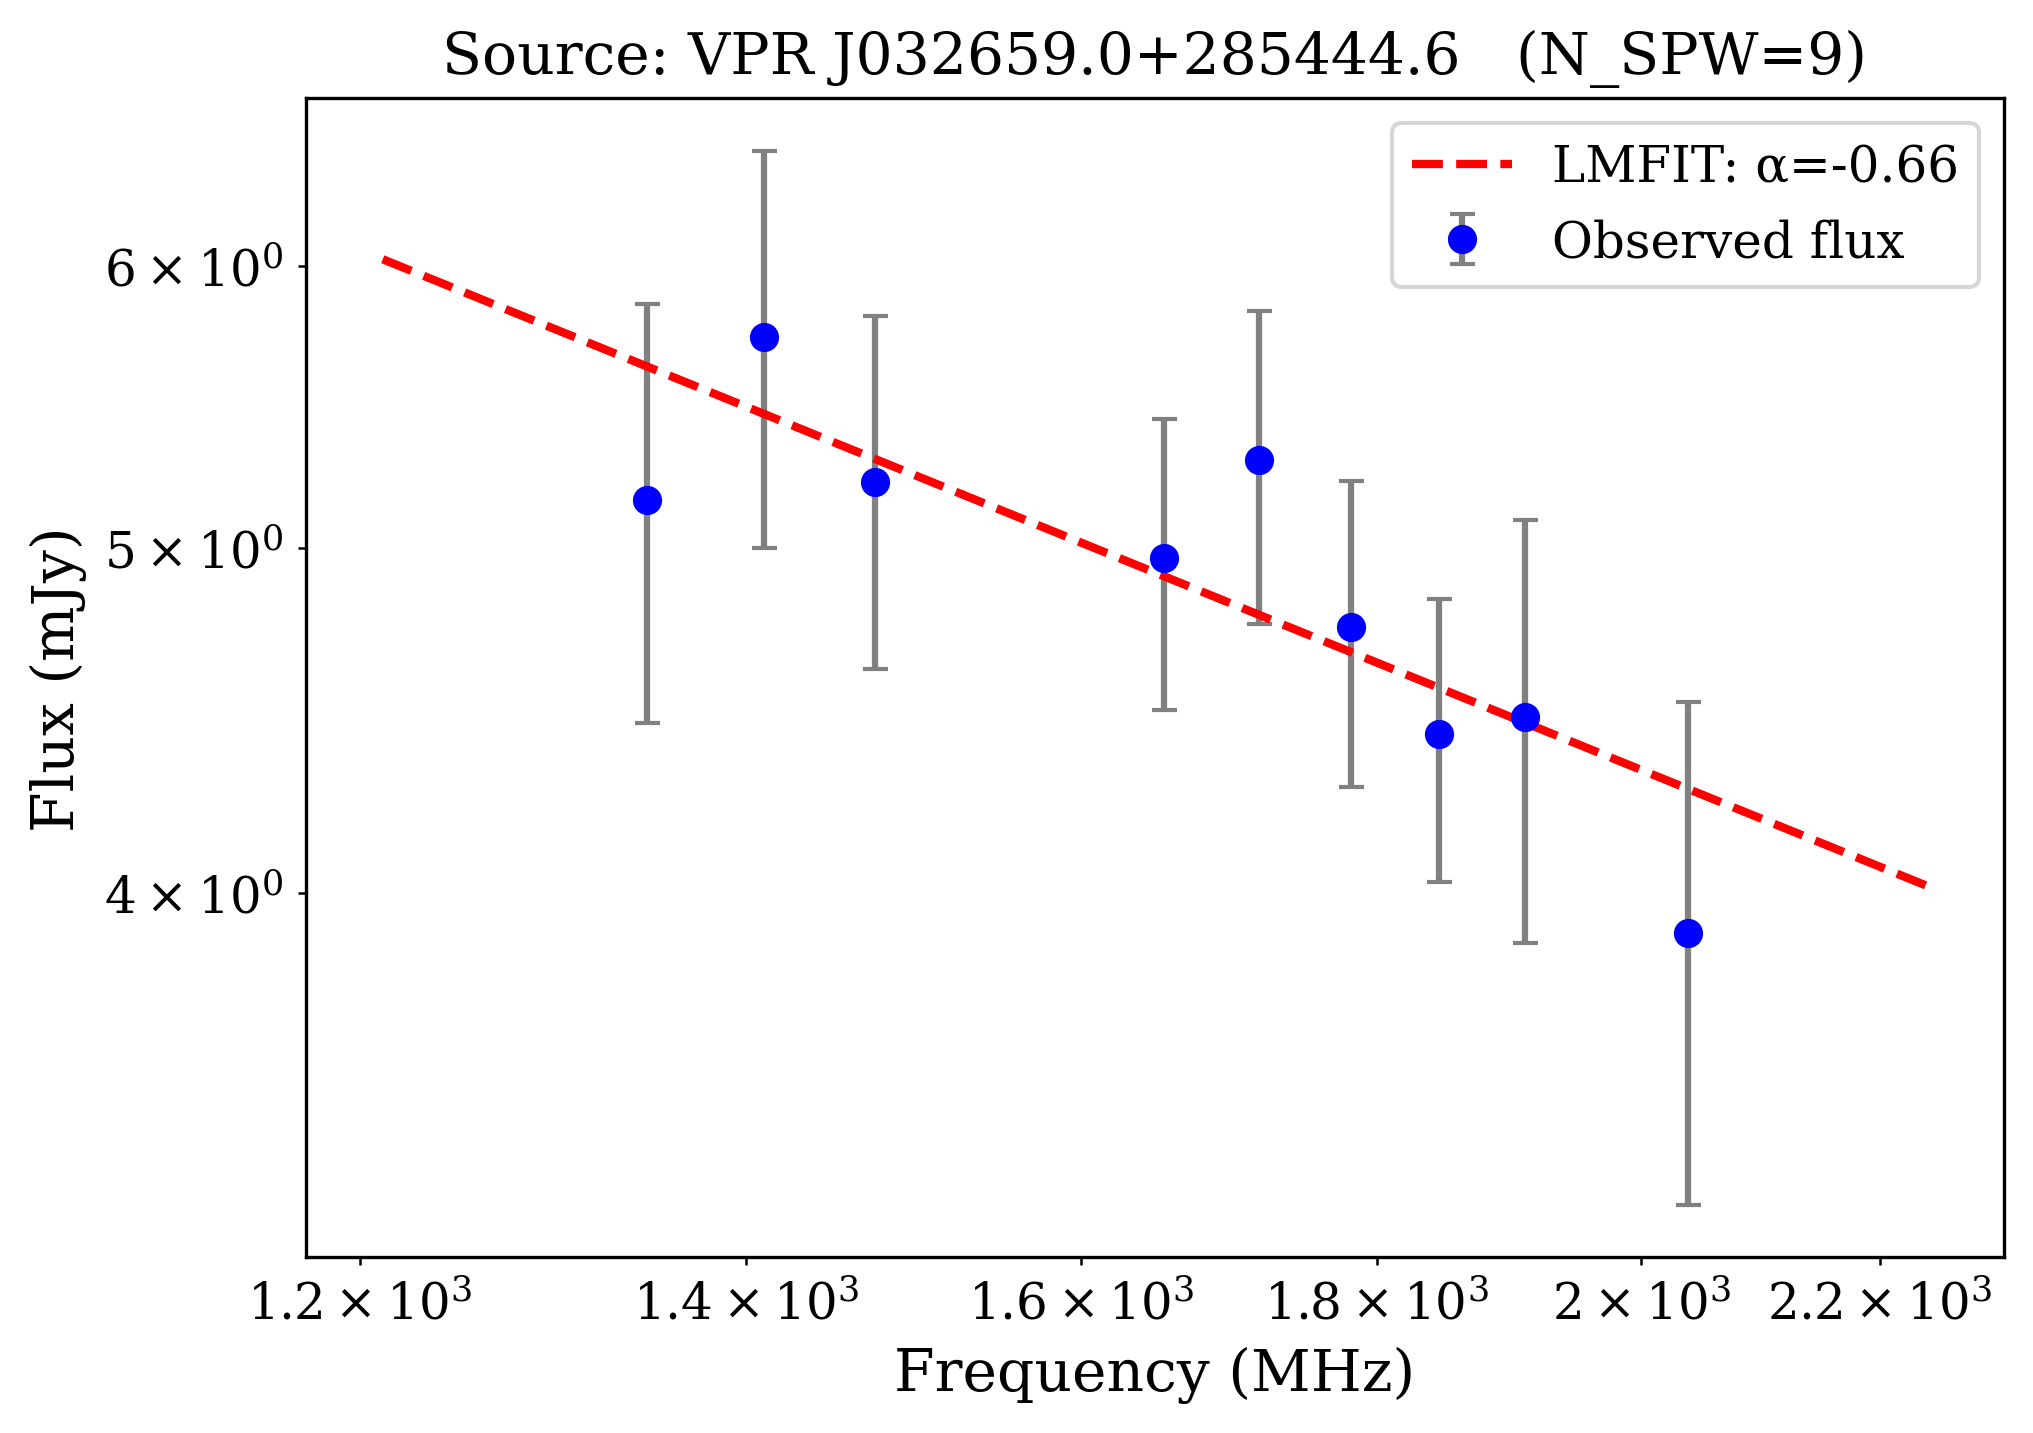

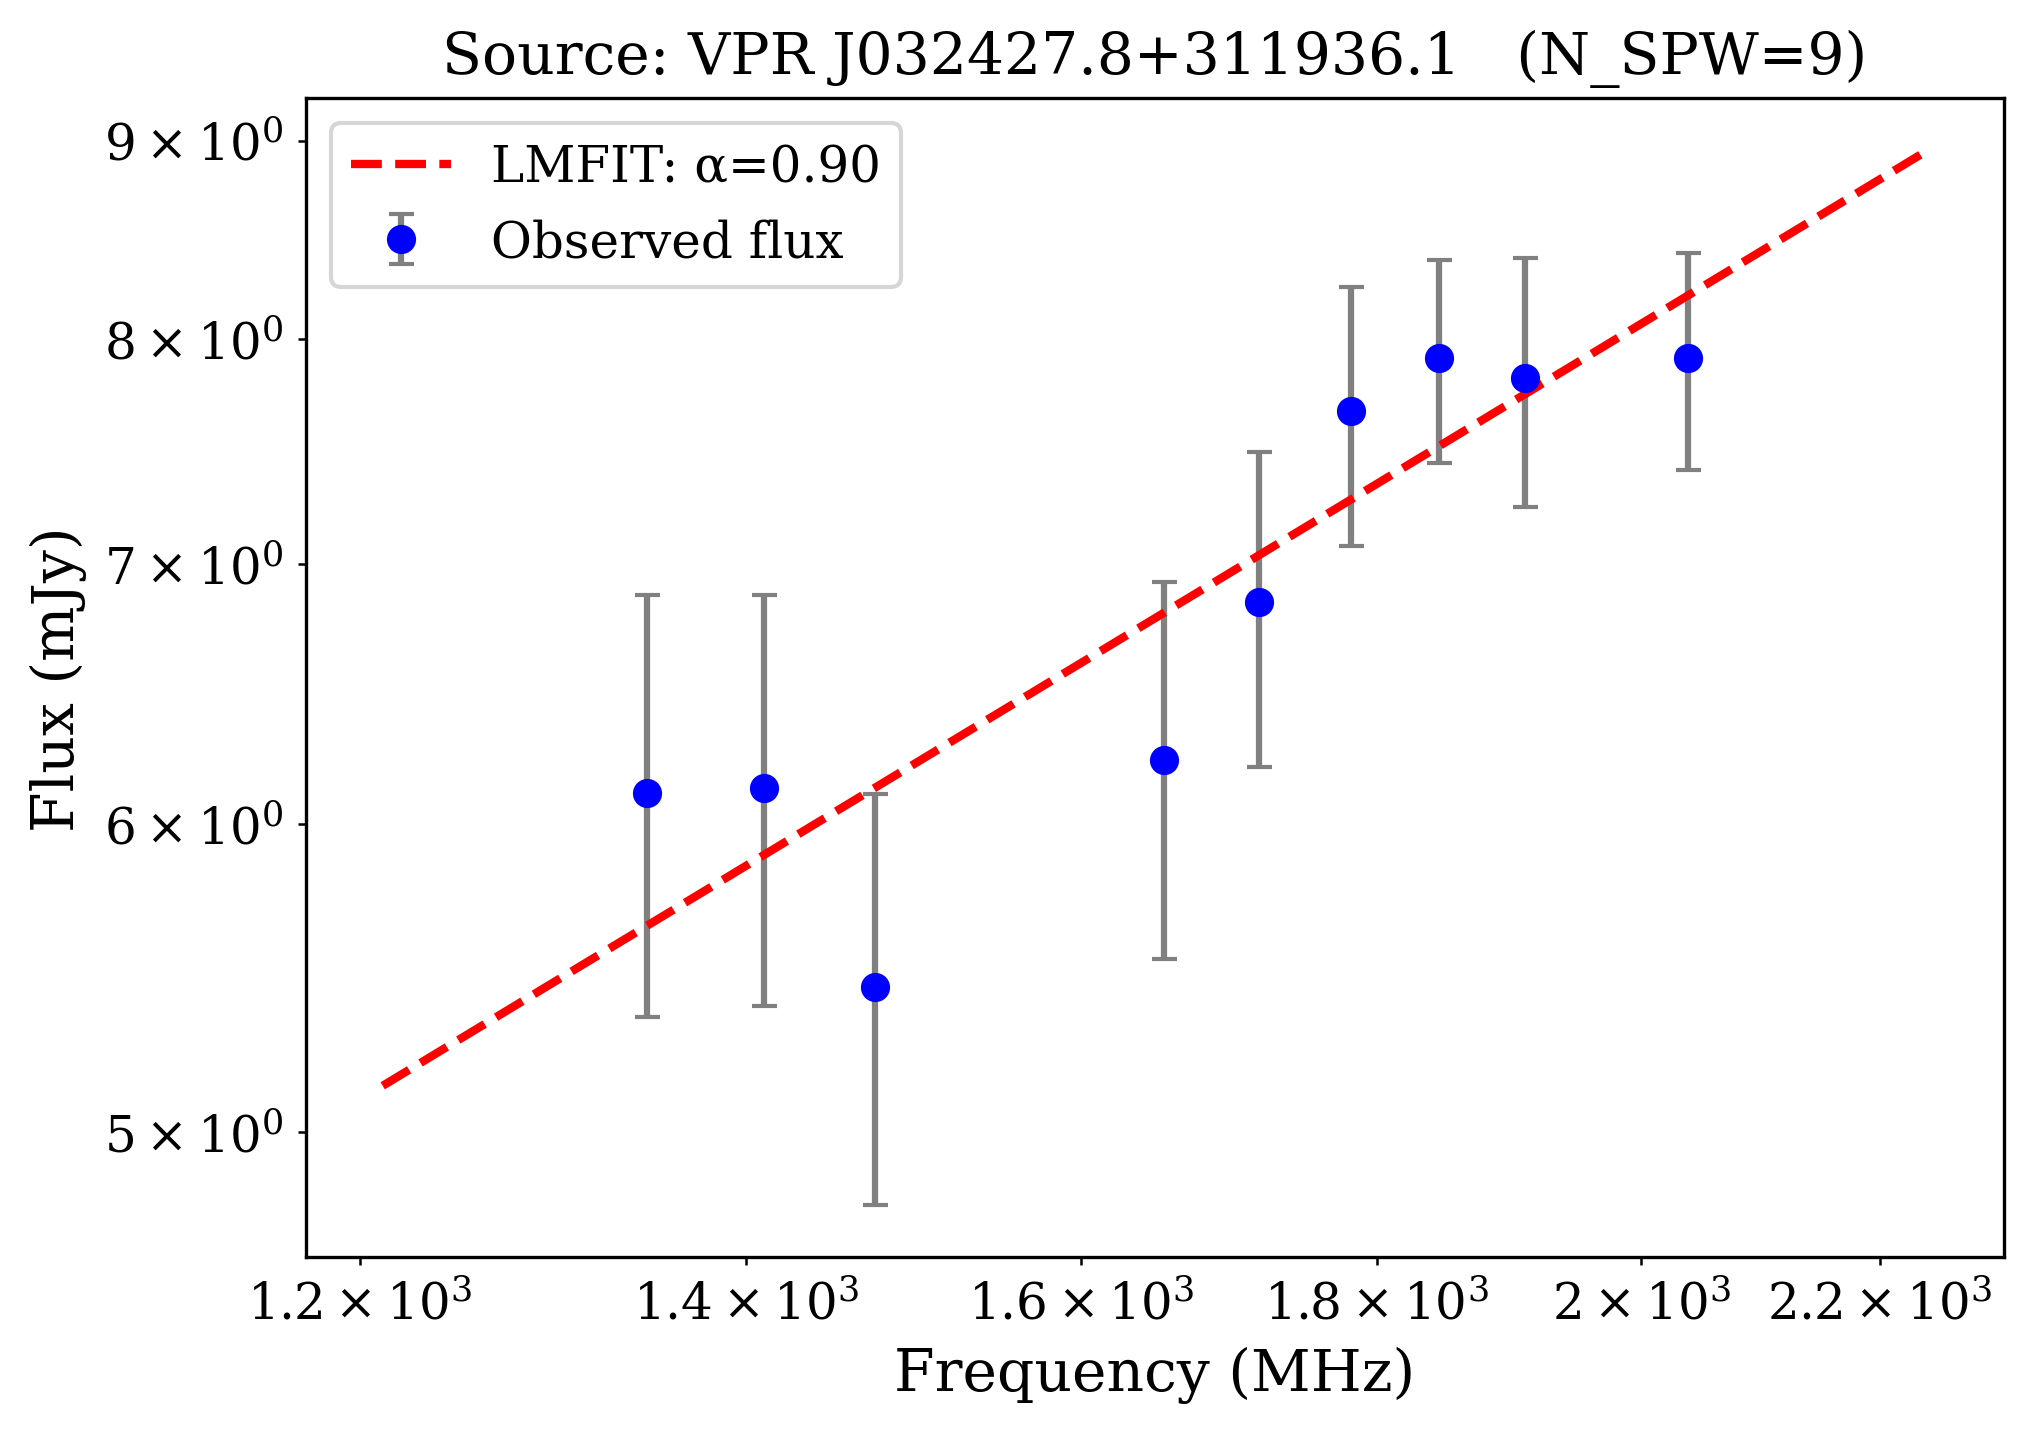

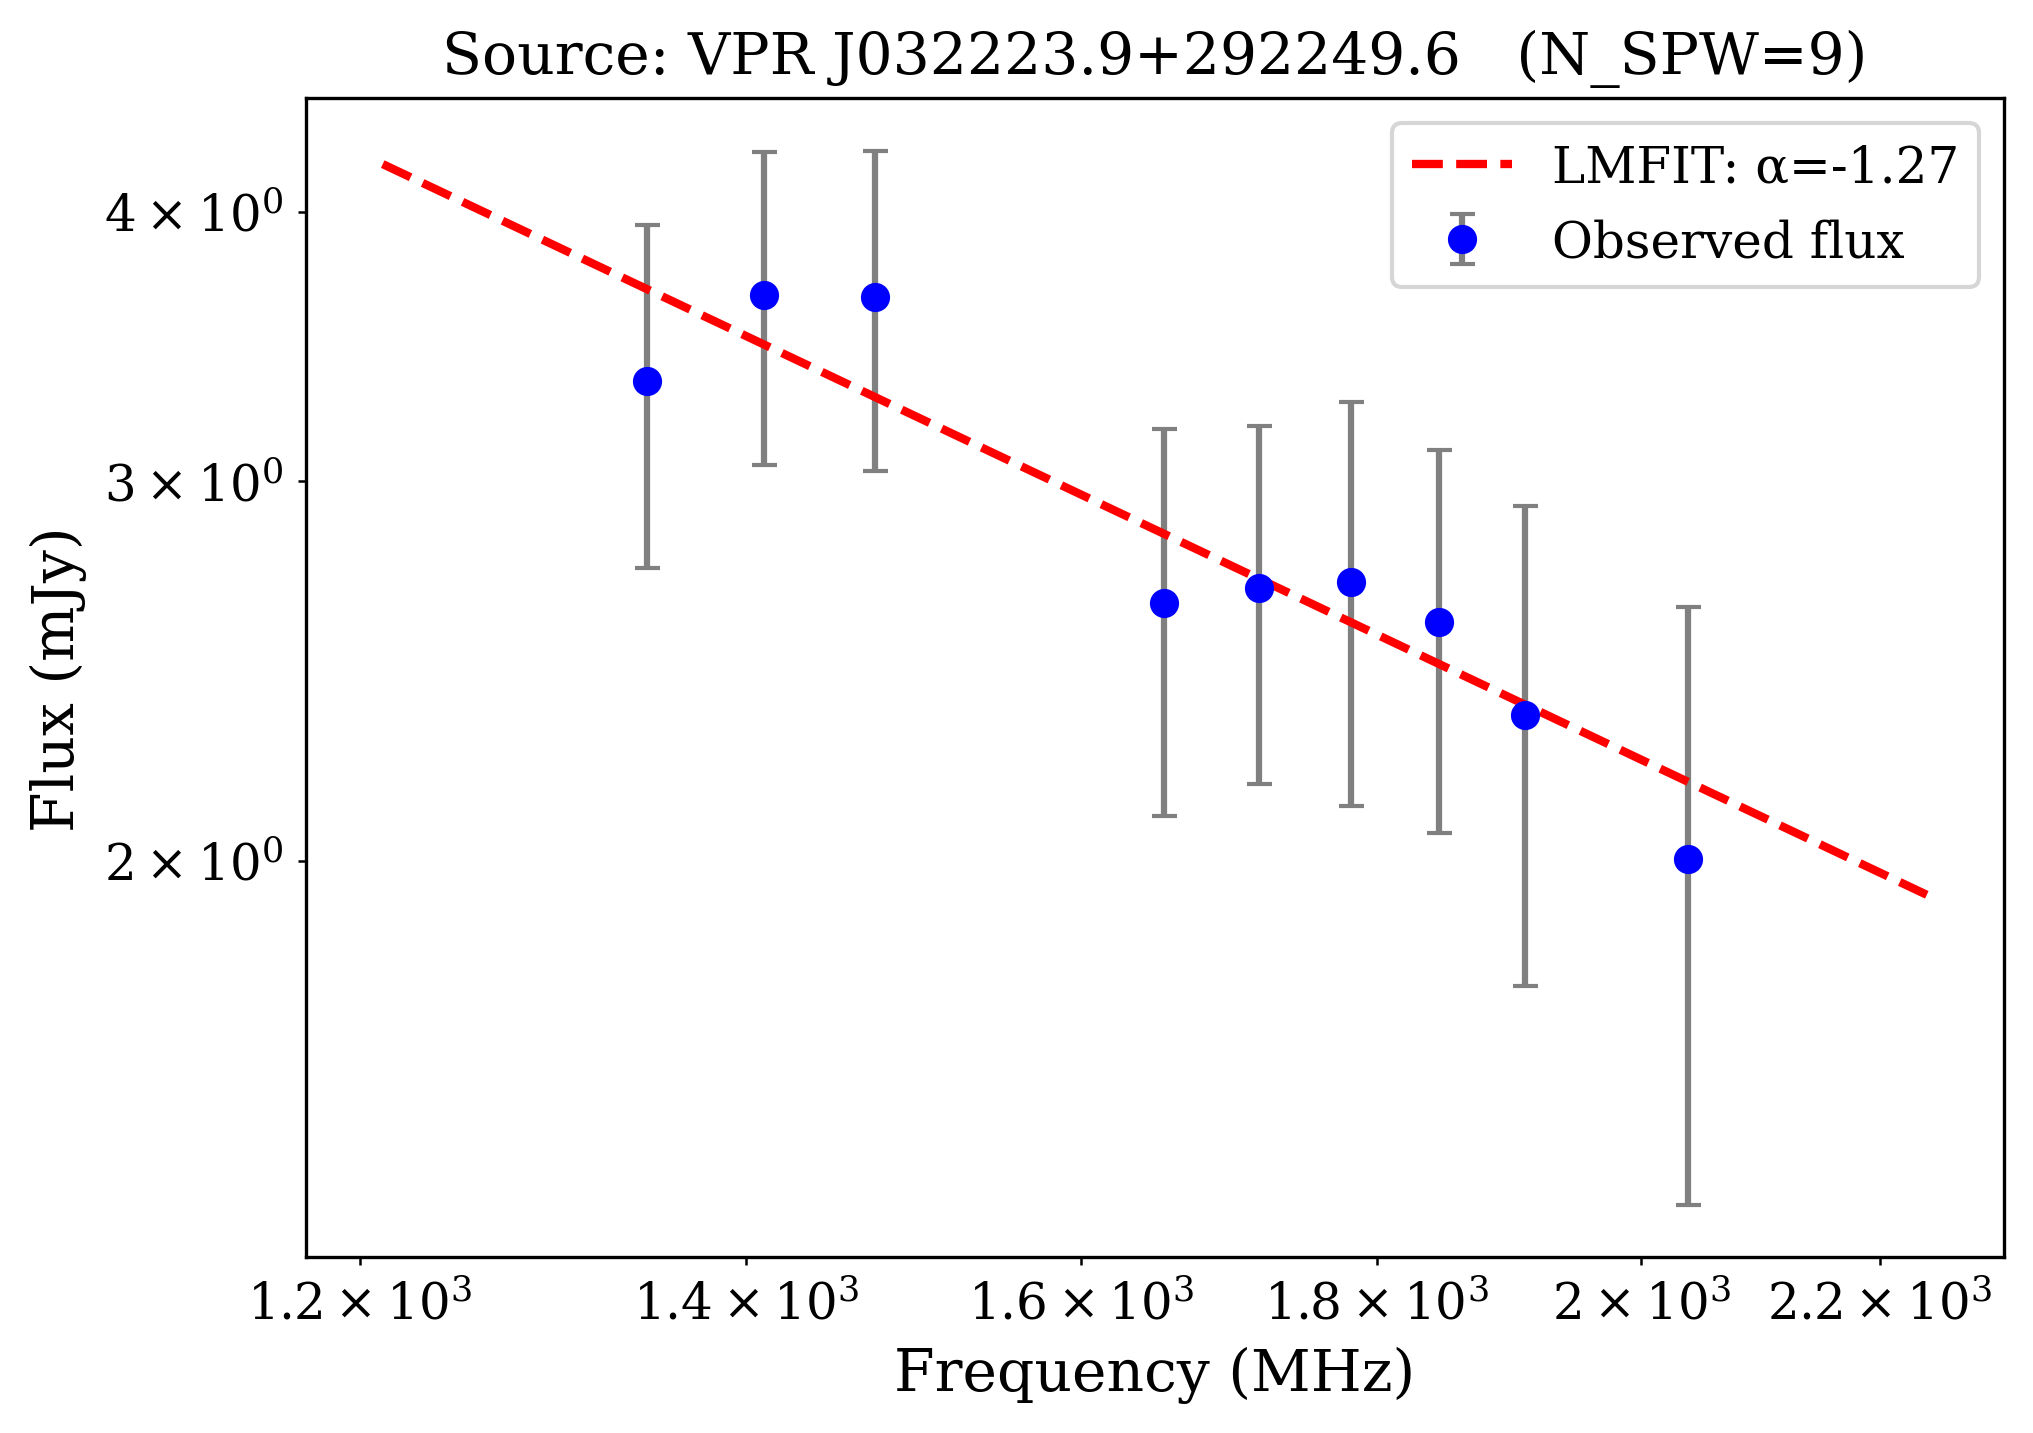

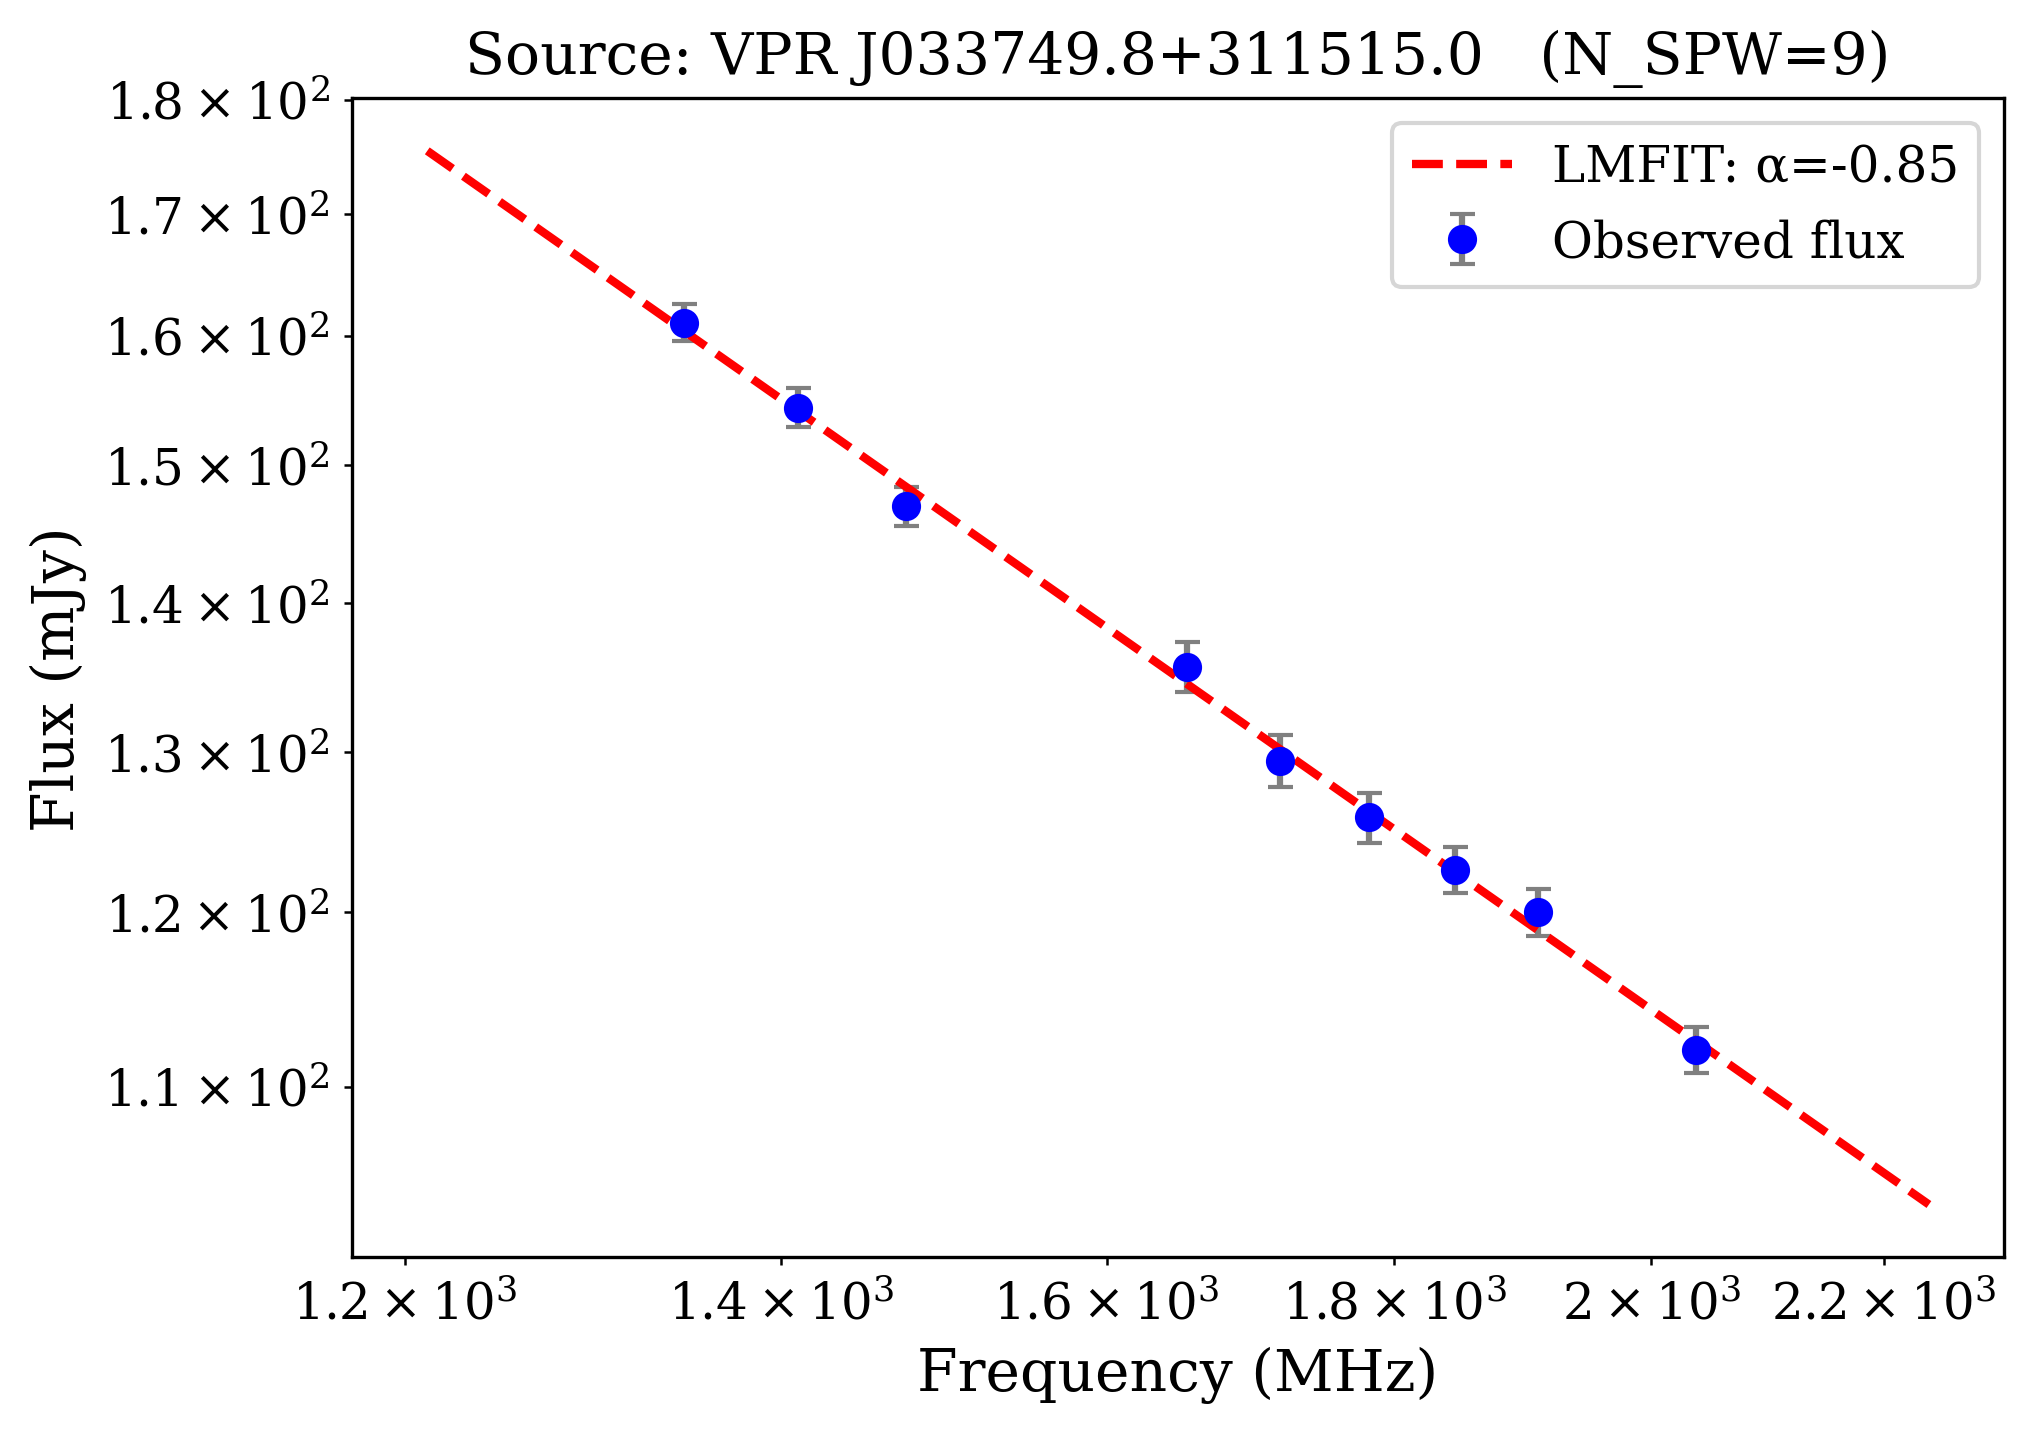

In [14]:
# ======================================
# CELL: PLOT RANDOM GOOD-FIT SOURCES
# Log(flux) vs Log(freq) + LMFIT model
# ======================================

import numpy as np
import matplotlib.pyplot as plt

N_PLOTS = 5  # how many random sources to plot

# Pick random good sources
rnd_sources = alpha_good_lmfit.sample(N_PLOTS, random_state=150)

for _, src in rnd_sources.iterrows():
    sid = src["Source_ID"]

    # get the wide table row for this source
    row = df_sel[df_sel["Source_ID"] == sid].iloc[0]

    # extract observed spectrum
    freqs, fluxes, errors = extract_spectrum(row)

    # skip if something is wrong
    if len(freqs) < 2:
        continue

    # === lmfit results ===
    A_fit     = src["A_lmfit"]
    alpha_fit = src["alpha_lmfit"]

    # model curve (smooth)
    nu_model = np.linspace(min(freqs)*0.9, max(freqs)*1.1, 200)
    S_model  = power_law(nu_model, A_fit, alpha_fit)

    # === Plot in log-log space ===
    plt.figure(figsize=(7, 5))
    
    plt.errorbar(
        freqs,
        fluxes,
        yerr=errors,
        fmt='o',
        color='blue',
        ecolor='gray',
        label='Observed flux',
        capsize=3
    )

    plt.plot(
        nu_model,
        S_model,
        'r--',
        linewidth=2,
        label=f"LMFIT: α={alpha_fit:.2f}"
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Flux (mJy)")
    plt.title(f"Source: {sid}   (N_SPW={src['N_SPW_used']})")

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


Source: VPR J033457.1+304925.3
  N_SPW      = 9
  alpha      = -0.687 ± 0.029
  chi2_red   = 0.712


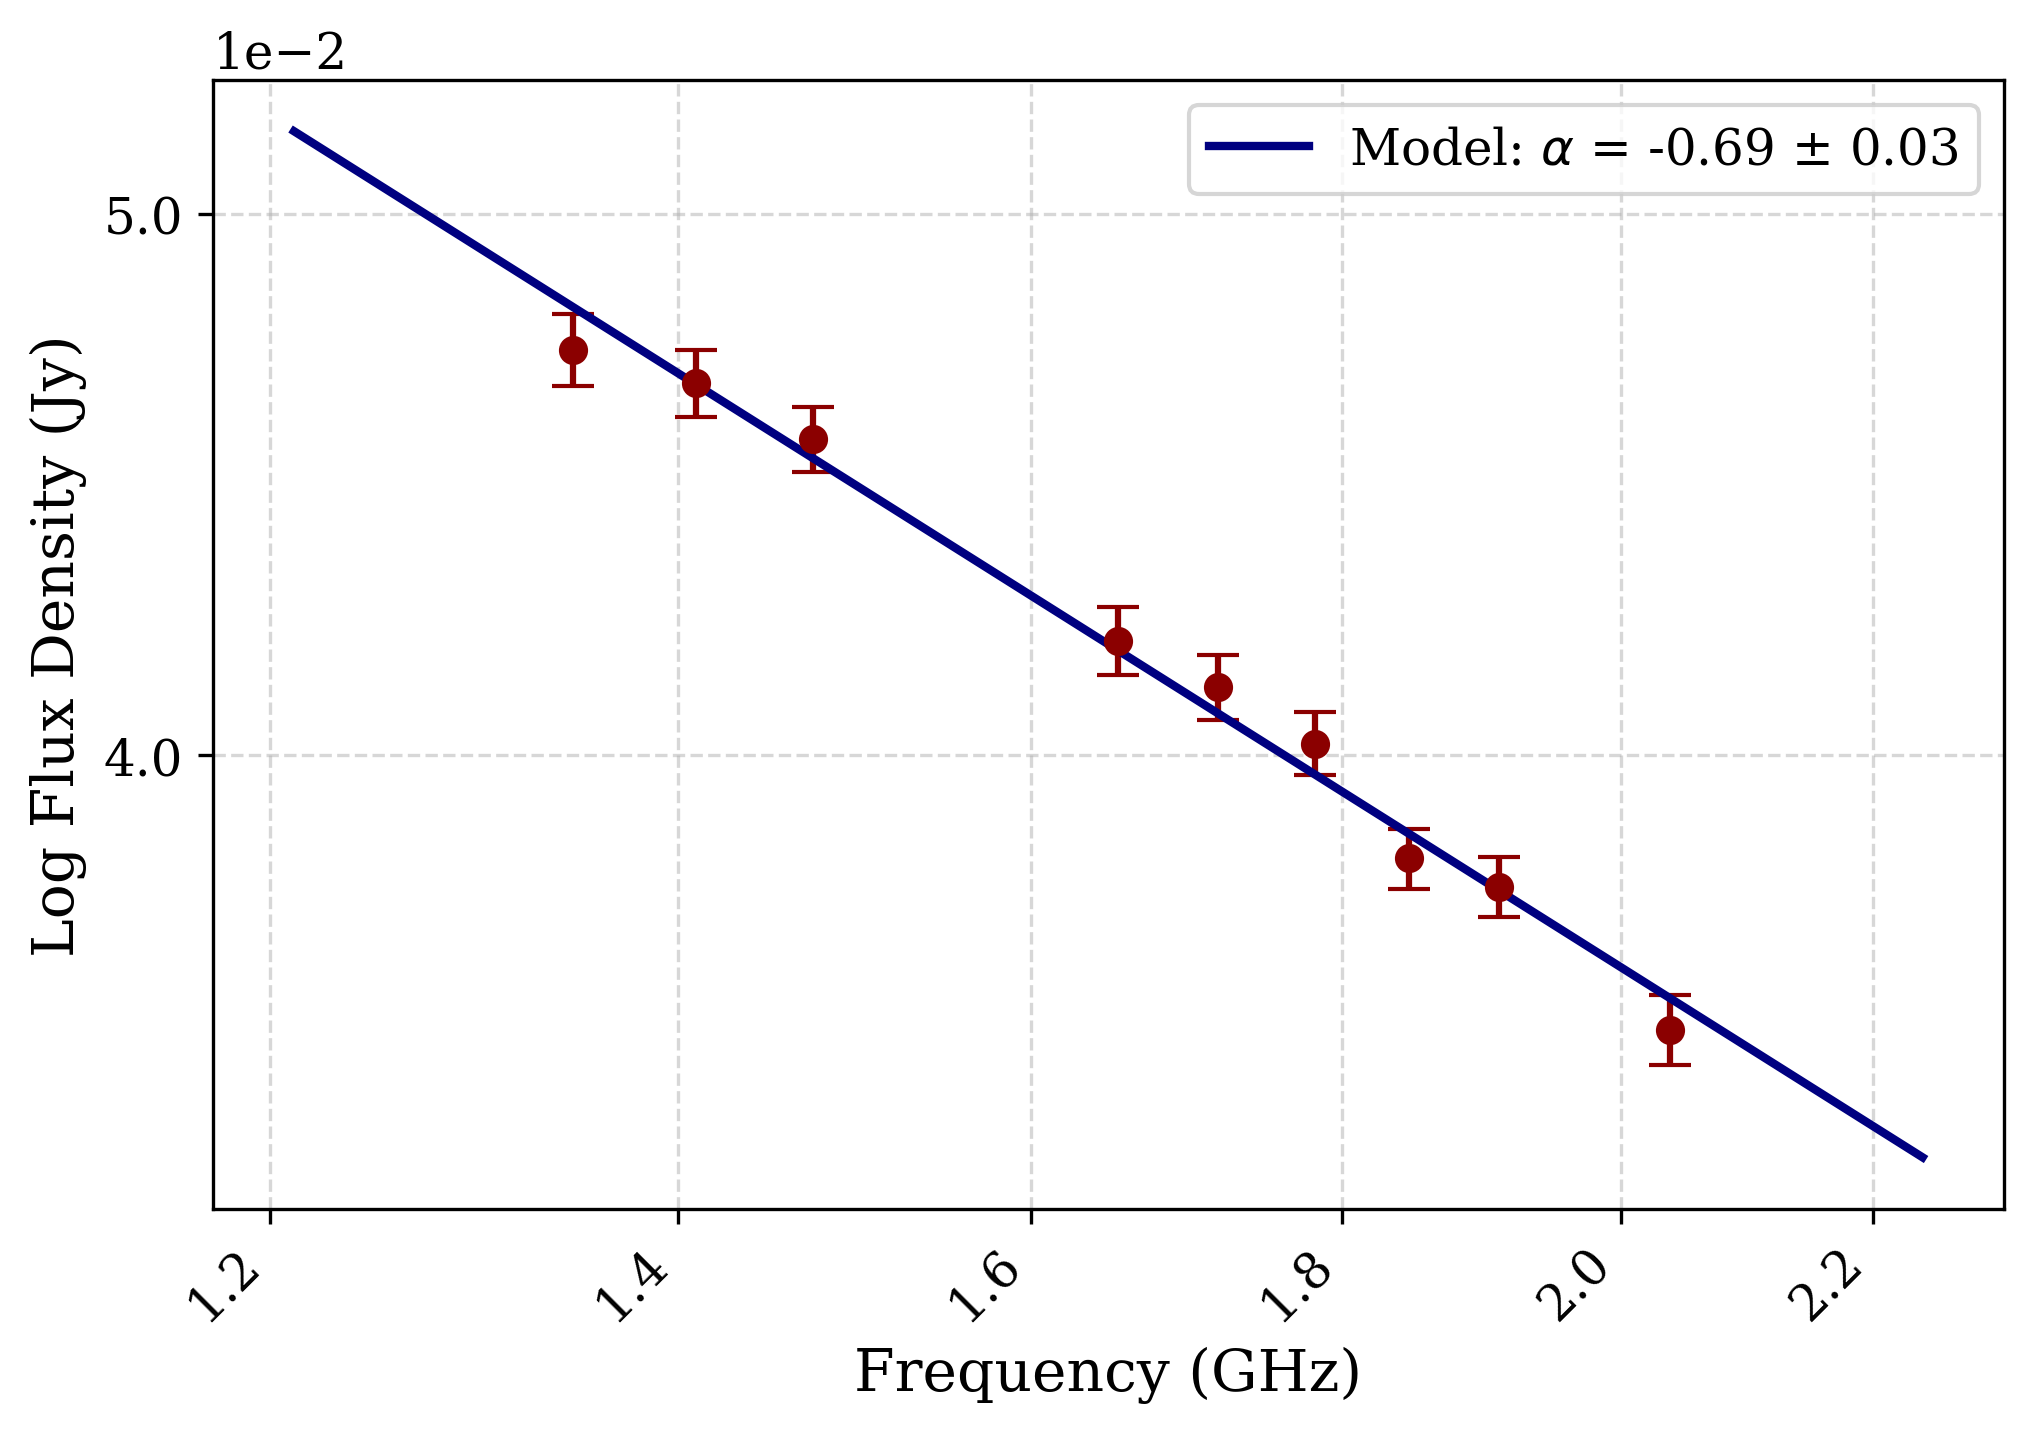

In [15]:
# ======================================
# PLOT SPECTRUM FOR ONE SPECIFIC SOURCE
# Styled like the example figure
# ======================================

from matplotlib.ticker import ScalarFormatter, LogLocator

source_id = "VPR J033457.1+304925.3"

# get the row from the big table (no filters)
row = df[df["Source_ID"] == source_id]

if row.empty:
    print(f"⚠️ Source {source_id} not found in df.")
else:
    row = row.iloc[0]

    # extract spectrum (MHz, mJy)
    freqs_MHz, fluxes_mJy, errors_mJy = extract_spectrum(row)

    if len(freqs_MHz) < 2:
        print(f"⚠️ Source {source_id}: not enough valid SPWs to plot.")
    else:
        # --- fit lmfit power-law: S(nu) = A * (nu/NU0)^alpha (nu in MHz) ---
        params = pl_model.make_params(
            A=np.median(fluxes_mJy),
            alpha=-0.7
        )

        fit_result = pl_model.fit(
            fluxes_mJy,
            params,
            nu=freqs_MHz,
            weights=1.0 / errors_mJy
        )

        A_fit     = fit_result.params["A"].value
        alpha_fit = fit_result.params["alpha"].value
        e_alpha   = fit_result.params["alpha"].stderr
        chi2_red  = fit_result.redchi
        n_spw     = len(freqs_MHz)

        print(f"Source: {source_id}")
        print(f"  N_SPW      = {n_spw}")
        print(f"  alpha      = {alpha_fit:.3f} ± {e_alpha:.3f}")
        print(f"  chi2_red   = {chi2_red:.3f}")

        # ---------- convert units for plotting ----------
        # x: MHz -> GHz
        freqs_GHz = freqs_MHz / 1000.0

        # y: mJy -> Jy
        fluxes_Jy = fluxes_mJy / 1000.0
        errors_Jy = errors_mJy / 1000.0

        # model curve in same units
        nu_model_MHz = np.linspace(freqs_MHz.min()*0.9, freqs_MHz.max()*1.1, 200)
        flux_model_mJy = power_law(nu_model_MHz, A_fit, alpha_fit)
        nu_model_GHz   = nu_model_MHz / 1000.0
        flux_model_Jy  = flux_model_mJy / 1000.0

        # -------- PLOT (log–log) in the requested style --------
        fig, ax = plt.subplots(figsize=(7, 5))

        ax.errorbar(
            freqs_GHz,
            fluxes_Jy,
            yerr=errors_Jy,
            fmt='o',
            color='darkred',
            ecolor='darkred',
            capsize=5,
            markersize=6
        )

        ax.plot(
            nu_model_GHz,
            flux_model_Jy,
            color='navy',
            linewidth=2,
            label=rf'Model: $\alpha$ = {alpha_fit:.2f} ± {e_alpha:.2f}'
        )

        # === Log–log scale ===
        ax.set_xscale('log')
        ax.set_yscale('log')

        # === X-axis formatting (GHz) ===
        ax.set_xlabel('Frequency (GHz)')
        ax.xaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(axis='x', style='plain')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # === Y-axis formatting (Jy) ===
        ax.set_ylabel('Log Flux Density (Jy)')
        ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.get_major_formatter().set_scientific(True)
        ax.yaxis.get_major_formatter().set_powerlimits((0, 0))

        ax.legend()
        ax.grid(True, which='both', ls='--', alpha=0.5)
        plt.savefig('../paper1/figs/spectral_fit.pdf', dpi=300, bbox_inches='tight')
        plt.tight_layout()
        
        plt.show()


# Alpha to big table

In [16]:
# ======================================
# MERGE LMFIT α INTO BIG TABLE AS:
#     alpha
#     E_alpha
# ======================================

import pandas as pd

# ------------------------------
# Paths
# ------------------------------
BIG_TABLE_PATH   = "../paper1/csv/combined_sources_all_spw.csv"
ALPHA_TABLE_PATH = "../paper1/csv/good_alpha_lmfit.csv"   # your saved file
OUTPUT_PATH      = "../paper1/csv/combined_sources_with_alpha.csv"

# ------------------------------
# Load tables
# ------------------------------
df_big = pd.read_csv(BIG_TABLE_PATH)
df_alpha = pd.read_csv(ALPHA_TABLE_PATH)

print("Big table shape:   ", df_big.shape)
print("Alpha table shape: ", df_alpha.shape)

# ------------------------------
# Keep only α columns and rename
# ------------------------------
alpha_small = df_alpha[
    ["Source_ID", "alpha_lmfit", "E_alpha_lmfit"]
].drop_duplicates(subset=["Source_ID"])

alpha_small = alpha_small.rename(columns={
    "alpha_lmfit": "alpha",
    "E_alpha_lmfit": "E_alpha"
})

print("Alpha-small shape:", alpha_small.shape)

# ------------------------------
# Merge
# ------------------------------
df_merged = df_big.merge(alpha_small, on="Source_ID", how="left")

print("Merged table shape:", df_merged.shape)

# ------------------------------
# Save output
# ------------------------------
df_merged.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Saved updated table with α to:\n    {OUTPUT_PATH}")


Big table shape:    (1410, 50)
Alpha table shape:  (275, 4)
Alpha-small shape: (275, 3)
Merged table shape: (1410, 52)
✅ Saved updated table with α to:
    ../paper1/csv/combined_sources_with_alpha.csv
